## Loading of the Tweets Dataset

In [2]:
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [4]:
tweet_data = pd.read_json('drive/My Drive/Colab Notebooks/DSSC_NLP/Project/tweets.json')
tweet_data.shape

(20000, 14)

In [ ]:
tweet_data.head(3)

,date,tweet_id,user_name,user_id,user_verified,user_location,n_retweet,n_likes,hashtags,text,replies,n_replies,tweet_sentiment,text_cleaned
0,2021-04-26 00:00:00+00:00,1386809816530702337,POTUS,1349149096909668363,True,,19325,151789,[],Remember: If you received either the Pfizer or...,[],0,neu,"[rememb, receiv, pfizer, moderna, covid, vacci..."
1,2021-04-24 00:00:00+00:00,1385986330182574081,ryanaboyd,336962093,False,Los Angeles,9610,42334,[],The US government’s depraved policy of watchin...,[@ryanaboyd Stupid take in light of the last 2...,2,neg,"[govern, deprav, polici, watch, pandem, burn, ..."
2,2021-04-25 00:00:00+00:00,1386395715442778114,GalvinAlmanza,1087717031724625920,True,"New York, NY",6751,74479,[],Just read that a % of people are skipping 2nd ...,[@GalvinAlmanza Aside from injection sight sor...,17,neu,"[read, peopl, skip, vaccin, fear, effect, read..."


In [ ]:
for column in tweet_data.columns:
  if tweet_data[column].isna().values.any():
    print(column, 'check for NaN:', tweet_data[column].isna().values.any())

In [ ]:
tweet_data.describe()

,tweet_id,user_id,n_retweet,n_likes,n_replies
count,2.000000e+04,2.000000e+04,20000.000000,20000.000000,20000.000000
mean,1.386184e+18,3.892494e+17,6.597800,37.872100,0.377800
std,3.374603e+14,5.442195e+17,181.626089,1299.552597,1.415015
min,1.385652e+18,3.946000e+03,0.000000,0.000000,0.000000
25%,1.385906e+18,1.195297e+08,0.000000,0.000000,0.000000
50%,1.386162e+18,1.326700e+09,0.000000,1.000000,0.000000
75%,1.386470e+18,9.613396e+17,0.000000,5.000000,0.000000
max,1.387286e+18,1.386688e+18,19325.000000,151789.000000,44.000000


In [ ]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   date             20000 non-null  datetime64[ns, UTC]
 1   tweet_id         20000 non-null  int64              
 2   user_name        20000 non-null  object             
 3   user_id          20000 non-null  int64              
 4   user_verified    20000 non-null  bool               
 5   user_location    20000 non-null  object             
 6   n_retweet        20000 non-null  int64              
 7   n_likes          20000 non-null  int64              
 8   hashtags         20000 non-null  object             
 9   text             20000 non-null  object             
 10  replies          20000 non-null  object             
 11  n_replies        20000 non-null  int64              
 12  text_cleaned     20000 non-null  object             
 13  tweet_sentiment 

## Topic Modelling

In this section we are going to check if the downloaded tweets concern, for example, on: Pfzier, covid and vaccines. 

In [ ]:
! pip install emoji

     |████████████████████████████████| 133kB 14.8MB/s 


In [ ]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
import time # to know how long training took
import multiprocessing # to speed things up by parallelizing
import regex as re
import emoji
import spacy
nlp = spacy.load('en')

In [ ]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer('english')

In order to obtain the sets of keywords defining the topics, we have defined a preprocessing function used to make an hard variation reduction over tweets. This function apply some clean procedure likes:

- remove digits, hashtags, tagged user, links, date and so on;

- transform emojies;

- from upper case to lower case;

- remove stop words and no-sense words;

- apply stemming.


Thanks to that, tweets text will be ready to be used for the Topic modelling.

In [ ]:
def preprocess(tweet, merge_token = False, lemmatize = True):

  numbers = re.compile('[0-9]+') # digit
  users = re.compile('@[A-Za-z0\.-9_]+') # users tweet name
  puncts = re.compile('[\'/".,;!?\\:-]') # punctuations
  parens = re.compile('[()[\]{}]') # parenthesis
  hashes = re.compile('#[A-Za-z0\.-9_\']+') # hashes tweet

  links1 = re.compile('^(?:http://)?(?:www\\.)?twitter\\.com/(\\w+)$') # twitter links
  links2 = re.compile('http://t.co\/[^\s]+') # twitter links
  links3 = re.compile(r'http\S+') # twitter links

  dates1 = re.compile('[0-9]\{4\}-[0-9]\{2\}-[0-9]\{2\}') # ex. 2003-08-06
  dates2 = re.compile('[A-Z][a-z][a-z] [0-9][0-9]*, [0-9]\{4\}') # ex. Jan 3, 2003
  dates3 = re.compile('^(\d{1,2})\/(\d{1,2})\/(\d{2}|(19|20)\d{2})$') # ex. DD/MM/YY or DD/MM/YYYY or MM/DD/YY or MM/DD/YYYY

  tweet_string = tweet.lower()

  # transform emojies
  for char in tweet_string:
    if char in emoji.UNICODE_EMOJI_ALIAS_ENGLISH:
      tweet_string = tweet_string.replace(char, ' ' + char + ' ')

  tweet_string = emoji.demojize(tweet_string, language='en')

  tweet_string = re.sub(users, ' ', tweet_string)
  tweet_string = re.sub(hashes, ' ', tweet_string)
  tweet_string = re.sub(links1, ' ', tweet_string)
  tweet_string = re.sub(links2, ' ', tweet_string)
  tweet_string = re.sub(links3, ' ', tweet_string)

  tweet_string = re.sub(dates1, ' ', tweet_string)
  tweet_string = re.sub(dates2, ' ', tweet_string)
  tweet_string = re.sub(dates3, ' ', tweet_string)

  tweet_string = re.sub(numbers, ' ', tweet_string)
  tweet_string = re.sub(puncts, ' ', tweet_string)
  tweet_string = re.sub(parens, ' ', tweet_string)

  tweet_string = ' '.join(tweet_string.split()) # remove white space

  # remove stop words and no-sense words
  if lemmatize is True:
    tweet_list = [stemmer.stem(token.text) 
                    for token in nlp(tweet_string) 
                      if len(token) > 2 and not token.is_stop and 
                        token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'}]
  else:
     tweet_list = [token.text
                  for token in nlp(tweet_string) 
                    if len(token) > 2 and not token.is_stop and 
                      token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'}]
  
  if merge_token is True:
    tweet_list = ' '.join([word for word in tweet_list])
  

  #print(tweet)
  #print(tweet_string)
  #print(tweet_list)

  return tweet_list

In [ ]:
tweet_data['text_cleaned'] = tweet_data.text.apply(preprocess, args = (False, True))

At this point we prepare tweets text to be filled into an LDA Model (number of topics is fixed to 5).

In [ ]:
limit= 20000

# run on 50000 instances
instances = tweet_data.text_cleaned[:limit]
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=50, no_above=0.3)
print(dictionary, flush=True)

creating dictionary
Dictionary(706 unique tokens: ['covid', 'dose', 'moderna', 'need', 'protect']...)


In [ ]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [ ]:
num_topics = 5

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print('chunk size', chunk_size)

print("fitting model", flush=True)
lda_model = LdaMulticore(num_topics=num_topics, # number of topics
                        corpus=model_corpus, # what to train on 
                        id2word=dictionary, # mapping from IDs to words
                        workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                        passes=num_passes, # make this many passes over data
                        chunksize=chunk_size, # update after this many instances
                        alpha=0.5)

chunk size 1000.0
fitting model


In [ ]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.024*"jab" + 0.020*"wait" + 0.018*"fulli" + 0.016*"think" + 0.015*"go" + '
  '0.015*"work" + 0.015*"look" + 0.014*"better" + 0.013*"tomorrow" + '
  '0.013*"week"'),
 (1,
  '0.084*"dose" + 0.081*"got" + 0.070*"shot" + 0.063*"second" + 0.054*"effect" '
  '+ 0.040*"today" + 0.035*"get" + 0.031*"feel" + 0.029*"arm" + 0.027*"day"'),
 (2,
  '0.036*"covid" + 0.035*"peopl" + 0.031*"receiv" + 0.028*"israel" + '
  '0.024*"heart" + 0.023*"case" + 0.020*"india" + 0.019*"inflamm" + '
  '0.018*"world" + 0.018*"examin"'),
 (3,
  '0.038*"moderna" + 0.031*"deal" + 0.029*"time" + 0.020*"know" + 0.020*"said" '
  '+ 0.018*"booster" + 0.017*"j&ampj" + 0.017*"canada" + 0.017*"come" + '
  '0.016*"problem"'),
 (4,
  '0.027*"avail" + 0.026*"appoint" + 0.022*"covid" + 0.020*"new" + '
  '0.020*"need" + 0.019*"moderna" + 0.017*"pfizerbiontech" + 0.017*"amp" + '
  '0.016*"astrazeneca" + 0.015*"read"')]


In [ ]:
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                lda_model.print_topics(num_topics=num_topics, num_words=10)]

for i, m in model_topics:
    print(i+1, ", ".join(m[:10]))

1 "jab", "wait", "fulli", "think", "go", "work", "look", "better", "tomorrow", "week"
2 "dose", "got", "shot", "second", "effect", "today", "get", "feel", "arm", "day"
3 "covid", "peopl", "receiv", "israel", "heart", "case", "india", "inflamm", "world", "examin"
4 "moderna", "deal", "time", "know", "said", "booster", "j&ampj", "canada", "come", "problem"
5 "avail", "appoint", "covid", "new", "need", "moderna", "pfizerbiontech", "amp", "astrazeneca", "read"


As we can see the topics are quite related to what we expect, i.e. Pfzier vaccines, and covid. 

Let's provide an interactive representation of the topics!

In [ ]:
! pip install pyLDAvis

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, ldacorpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.301999  0.232714       1        1  25.051222
2      0.215322  0.226593       2        1  21.367793
4      0.236362 -0.007991       3        1  21.267641
0     -0.192639 -0.181514       4        1  16.699251
3      0.042954 -0.269802       5        1  15.614093, topic_info=        Term         Freq        Total Category  logprob  loglift
94       got  2895.000000  2895.000000  Default  30.0000  30.0000
1       dose  3076.000000  3076.000000  Default  29.0000  29.0000
7     second  2261.000000  2261.000000  Default  28.0000  28.0000
23    effect  1942.000000  1942.000000  Default  27.0000  27.0000
8       shot  2912.000000  2912.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
2    moderna   837.491190  1434.514313   Topic5  -3.2834   1.3188
273    immun   226.772624   271.067767   Topic5  -4.5899   1.6786
269    month   228.997449   291.127592   Topic5  -4.5801   1.6169
22       amp   295.913608   876.789861   Topic5  -4.3237   0.7708
90      year   206.649155   617.309824   Topic5  -4.6828   0.7626

[217 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
606       1  0.005138        ach
606       2  0.005138        ach
606       3  0.005138        ach
606       4  0.986405        ach
606       5  0.005138        ach
...     ...       ...        ...
499       1  0.995411  yesterday
499       2  0.002027  yesterday
499       3  0.002027  yesterday
499       4  0.002027  yesterday
499       5  0.002027  yesterday

[910 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 1, 4])

## Entity Exploration

In [ ]:
tweets = [preprocess(tweet, True, True) for tweet in tweet_data.text]
tweets

['rememb receiv pfizer moderna covid vaccin need dose receiv scope protect skip second shot',
 'govern deprav polici watch pandem burn global south refus help vaccin hurt pfizer line good preview climat collaps probabl go unfold',
 'read peopl skip vaccin fear effect read twitter think get effect littl balanc hub amp ~zero effect pfizer littl tire scrub tub muffin today',
 'lobbi urg import pfizer vaccin januari want india buy pfizer care cost amp let peopl afford pay wait opportun lobbi whine india vaccin manufactur loot',
 'jeff bezo success stori dhirubhai ambani fraudster steve job dreamer gautam adani dream snatcher pfizer amp j&ampj make profit natur order thing sii make profit blasphemi countri self flagel',
 'paid pfizer gave moderna nih licens vaccin manufactur globe moral oblig presid biden demand',
 'cvs van ness washington dosag pfizer need use want wast spread word signup cvs websit ideal talk walkin connecticut ave pharmaci share',
 'pfizer let peopl afford pay covaxin or

In [ ]:
entities = [[(entity.text, entity.label_) 
            for entity in nlp(tweet).ents] 
              for tweet in tweets]

flat_entities = [entity_tuple 
                for entities_list in entities 
                  for entity_tuple in entities_list]

In [ ]:
import collections
print(collections.Counter([entity[1] for entity in flat_entities]).most_common(10))

[('ORG', 12706), ('PERSON', 7696), ('DATE', 5215), ('GPE', 3865), ('ORDINAL', 2499), ('NORP', 1260), ('TIME', 761), ('CARDINAL', 364), ('FAC', 181), ('LOC', 116)]


In [ ]:
most_entity = collections.Counter([entity[1] for entity in flat_entities]).most_common(10)
most_entity = {entity : count for entity, count in most_entity}

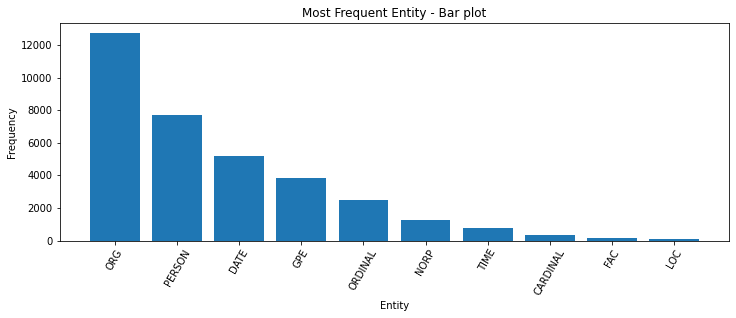

In [ ]:
tweet_bar_plot(most_entity, 'Most Frequent Entity - Bar plot', 'Entity', 'Frequency', image_name = 'frequent_entity')

In [ ]:
collections.Counter(flat_entities).most_common(10)

[(('india', 'GPE'), 17),
 (('pfizer', 'ORG'), 14),
 (('second', 'ORDINAL'), 10),
 (('pfizer moderna', 'ORG'), 6),
 (('indian', 'NORP'), 6),
 (('today', 'DATE'), 5),
 (('american', 'NORP'), 4),
 (('pfizer vaccin', 'ORG'), 4),
 (('washington', 'GPE'), 3),
 (('jeff bezo', 'PERSON'), 2)]

In [ ]:
entity = 'pfizer'
tag = 'ORG'

entity_df = list()
for idx in range(len(entities)):
  for entity_tuple in entities[idx]:
      if entity_tuple[0] == entity and entity_tuple[1] == tag:
        date = tweet_data.at[idx, 'date']
        sentiment = tweet_data.at[idx, 'tweet_sentiment']
        entity_df.append([date, sentiment])

entity_df = pd.DataFrame(entity_df, columns=['date', 'tweet_sentiment'])
entity_df.sort_values(by=['date'], ascending=False, inplace=True)

print(entity_df)

                          date tweet_sentiment
1072 2021-04-28 00:00:00+00:00             neg
212  2021-04-28 00:00:00+00:00             neg
0    2021-04-27 00:00:00+00:00             neu
1541 2021-04-26 00:00:00+00:00             neg
1548 2021-04-26 00:00:00+00:00             pos
...                        ...             ...
638  2021-04-23 00:00:00+00:00             neu
639  2021-04-23 00:00:00+00:00             neu
654  2021-04-23 00:00:00+00:00             neg
655  2021-04-23 00:00:00+00:00             neg
2093 2021-04-23 00:00:00+00:00             neu

[2094 rows x 2 columns]


In [ ]:
sentiment_freq = list()
for date in entity_df.date.unique():
  sentiments = entity_df[entity_df.date == date].tweet_sentiment
  for idx in range(len(list(sentiments.value_counts()))):
    sentiment_freq.append([date, list(sentiments.unique())[idx], list(sentiments.value_counts())[idx]])

sentiment_freq[:20]

[[Timestamp('2021-04-28 00:00:00+0000', tz='UTC'), 'neg', 2],
 [Timestamp('2021-04-27 00:00:00+0000', tz='UTC'), 'neu', 1],
 [Timestamp('2021-04-26 00:00:00+0000', tz='UTC'), 'neg', 173],
 [Timestamp('2021-04-26 00:00:00+0000', tz='UTC'), 'pos', 139],
 [Timestamp('2021-04-26 00:00:00+0000', tz='UTC'), 'neu', 134],
 [Timestamp('2021-04-25 00:00:00+0000', tz='UTC'), 'pos', 230],
 [Timestamp('2021-04-25 00:00:00+0000', tz='UTC'), 'neu', 203],
 [Timestamp('2021-04-25 00:00:00+0000', tz='UTC'), 'neg', 159],
 [Timestamp('2021-04-24 00:00:00+0000', tz='UTC'), 'pos', 286],
 [Timestamp('2021-04-24 00:00:00+0000', tz='UTC'), 'neu', 247],
 [Timestamp('2021-04-24 00:00:00+0000', tz='UTC'), 'neg', 212],
 [Timestamp('2021-04-23 00:00:00+0000', tz='UTC'), 'neg', 129],
 [Timestamp('2021-04-23 00:00:00+0000', tz='UTC'), 'neu', 96],
 [Timestamp('2021-04-23 00:00:00+0000', tz='UTC'), 'pos', 83]]

In [ ]:
entity_df = pd.DataFrame(sentiment_freq, columns=['date', 'tweet_sentiment', 'sentiment_freq'])
entity_df

,date,tweet_sentiment,sentiment_freq
0,2021-04-28 00:00:00+00:00,neg,2
1,2021-04-27 00:00:00+00:00,neu,1
2,2021-04-26 00:00:00+00:00,neg,173
3,2021-04-26 00:00:00+00:00,pos,139
4,2021-04-26 00:00:00+00:00,neu,134
5,2021-04-25 00:00:00+00:00,pos,230
6,2021-04-25 00:00:00+00:00,neu,203
7,2021-04-25 00:00:00+00:00,neg,159
8,2021-04-24 00:00:00+00:00,pos,286
9,2021-04-24 00:00:00+00:00,neu,247


In [ ]:
entity_df = pd.pivot_table(entity_df, values='sentiment_freq', index='date',
                    columns='tweet_sentiment', fill_value=0)

entity_df.reset_index(inplace = True)
entity_df.columns.name = ''

entity_df

,date,neg,neu,pos
0,2021-04-23 00:00:00+00:00,129,96,83
1,2021-04-24 00:00:00+00:00,212,247,286
2,2021-04-25 00:00:00+00:00,159,203,230
3,2021-04-26 00:00:00+00:00,173,134,139
4,2021-04-27 00:00:00+00:00,0,1,0
5,2021-04-28 00:00:00+00:00,2,0,0


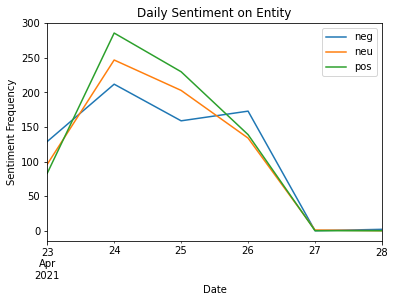

In [ ]:
entity_df.plot(x = 'date', xlabel = 'Date', ylabel = 'Sentiment Frequency', title = 'Daily Sentiment on Entity')
plt.savefig('entity_sentiment.png')

## PMI

In [ ]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
import collections
import operator

words = [word for tweet in tweet_data.text_cleaned for word in tweet]
         
finder = BigramCollocationFinder.from_words(words)
bgm = BigramAssocMeasures()
score = bgm.mi_like # mutual information like measure

collocations = collections.Counter({'_'.join(bigram): pmi for bigram, pmi in finder.score_ngrams(score)}).most_common(20)
collocations

[('heart_inflamm', 331.86306036772936),
 ('raw_materi', 238.64735010105548),
 ('israel_examin', 198.43924083681662),
 ('examin_heart', 182.20487969946677),
 ('inflamm_case', 165.40877999270955),
 ('pfizer_vaccin', 142.22830399959227),
 ('neurolog_degen', 137.76822049574548),
 ('covid_vaccin', 116.62773784924163),
 ('caus_neurodegen', 112.5767490428124),
 ('al_neurolog', 109.09696748264523),
 ('alzheim_al', 106.58899121867637),
 ('sore_arm', 104.23652894782292),
 ('second_dose', 100.46546492238679),
 ('trigger_alzheim', 97.50470219435736),
 ('bee_gee', 85.0),
 ('pfizer_shot', 84.32763636328265),
 ('neurodegen_diseas', 82.58686233829631),
 ('gee_singer', 76.24691535150646),
 ('barri_gibb', 73.75173889780632),
 ('singer_barri', 71.57941347270615)]

## Descriptive Analysis

Now is the time to show some useful plots on our tweets data, that is done with bar plots, pie plots and more!

In [ ]:
import matplotlib.pyplot as plt

def tweet_bar_plot(data, title, x_label, y_label, feature_label = [], image_name = '', show_perc=False):
  plt.figure(figsize = (12,4))
  plt.xticks(rotation = 60)

  x = data.keys()
  y = data.values()

  y = list(y)
  plt.bar(x, y)

  if len(feature_label) > 0:
    for i in range(len(x)):
              plt.text(i, y[i], str(feature_label[i]), ha = 'center')
  elif show_perc is True:
    y_perc = [round(freq/sum(y), 2) for freq in y]

    for i in range(len(x)):
              plt.text(i, y[i], str(y_perc[i]) + '%', ha = 'center')

  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  if len(image_name) > 0:
    plt.savefig('{}.png'.format(image_name), bbox_inches='tight')

  plt.show()

In [ ]:
#tweet_data['time'] = tweet_data.time.apply(pd.to_datetime).dt.date

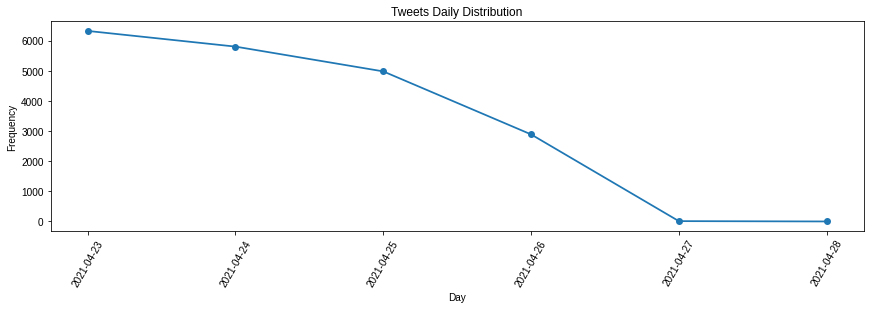

In [ ]:
import matplotlib.pyplot as plt

tweet_date = tweet_data.date.dt.date.value_counts()
tweet_date = dict(sorted(tweet_date.items(), key=operator.itemgetter(1),reverse=True))

fig = plt.figure(figsize = (12,4))
plt.xticks(rotation = 60)
plt.style.use('seaborn')

x = sorted(list(tweet_date.keys()))
y = list(tweet_date.values())

plt.plot_date(x, y, linestyle = 'solid')  
plt.tight_layout()

plt.title('Tweets Daily Distribution')
plt.xlabel('Day')
plt.ylabel('Frequency')

#fig.savefig('{}.png'.format(image_name), bbox_inches='tight')
plt.show()

In [ ]:
# create a dictionary to keep track of the frequency of words used in all tweets
word_freq = collections.Counter([word for tweet in tweet_data.text_cleaned for word in tweet])
word_freq_dic = dict(word_freq.most_common(30))
filtered_dic = dict((k, v) for k, v in word_freq_dic.items() if v >= 5) # frequency higher than 5...

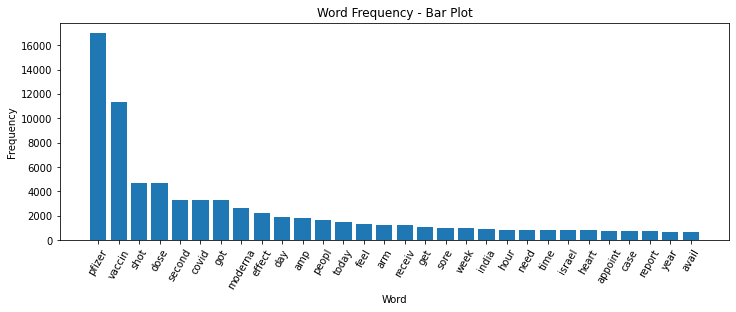

In [ ]:
tweet_bar_plot(filtered_dic, 'Word Frequency - Bar Plot', 'Word', 'Frequency', image_name = 'frequent_words')
# as we could expect, the most frequents words are related with the pandemic situation
# like pfzier, vaccin and covid

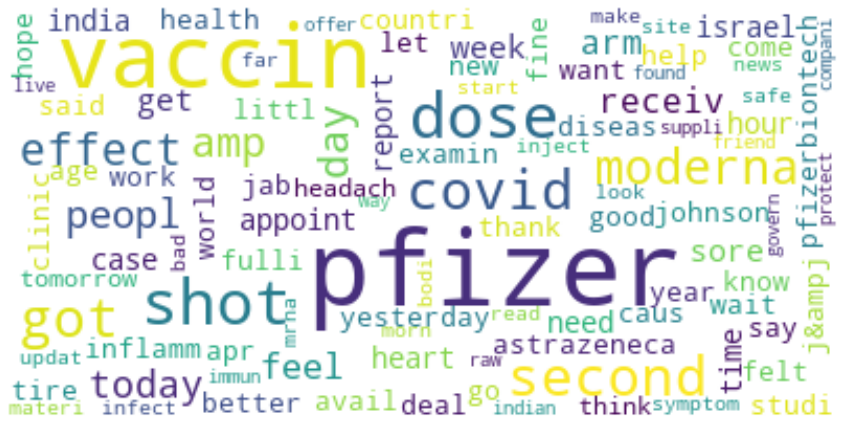

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# we propose a more fun representation of the most frequent words by means of a world cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, stopwords=STOPWORDS, background_color="white").generate_from_frequencies(word_freq)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

image_name = 'word_cloud'
if len(image_name) > 0:
  plt.savefig('{}.png'.format(image_name), bbox_inches='tight')

plt.show()

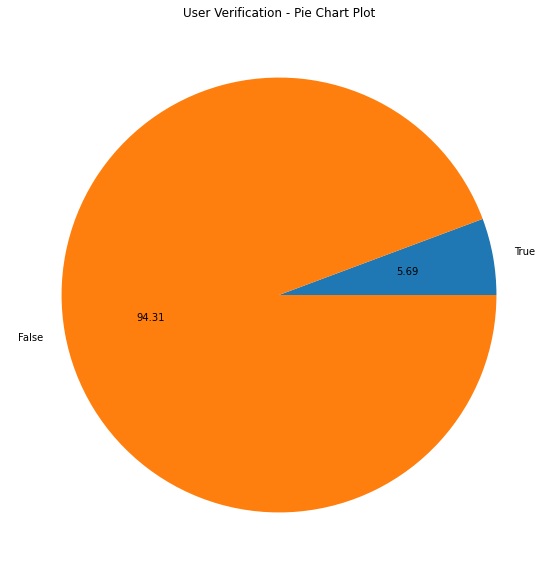

In [ ]:
# we might be interested in knowing how many of the users posting tweets are 
# authenticated. This could be a good cue to identify which of the non-authenticated 
# users might be trustworthy anyway. However, this type of analysis has not 
# been performed in this project.

# the pie plot shows us that a very higher percentage of the 
# users are notn-authenticated

fig = plt.figure(figsize = (10, 10))
user_verification = collections.Counter(tweet_data.user_verified)
plt.pie(user_verification.values(), labels = user_verification.keys(), autopct = "%.2f", textprops = {'fontsize': 14})
plt.title("User Verification - Pie Chart Plot")

image_name = 'verified_user'

if len(image_name) > 0:
  plt.savefig('verified_user.png', bbox_inches = 'tight')
  
plt.show()

In [ ]:
# we might be interested in understanding which hashtags are most present in tweets.
# In particular, it is worth bearing in mind that, in Twitter, hashtags can have 
# a big impact on public opinion as Twitter itself tends to propose those posts 
# that have particularly influential hashtags.

# the bar plot show us the 10 most common hashtags used in the tweets

hashtags = collections.Counter([hashtag for hashtags in tweet_data.hashtags for hashtag in hashtags]).most_common(10)
hashtags = {hashtag : count for hashtag, count in hashtags}
hashtags = dict(sorted(hashtags.items(), key=operator.itemgetter(1),reverse=True))

NameError: ignored

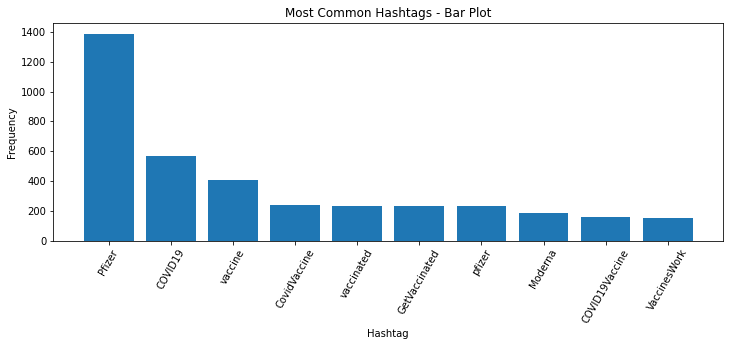

In [ ]:
tweet_bar_plot(hashtags, 'Most Common Hashtags - Bar Plot', 'Hashtag', 'Frequency', image_name = 'common_hashtags')

In [ ]:
# we might be interested in understanding the location of users based on the 
# location expressed by the user, in this case we preferred to exclude those 
# users who did not provide any (the vast majority). 

# the bar plot show us the 10 most common user location, it is good to consider
# that users can show an invented location, and the real user location is not
# possible to retrieve just by the tweet. So, we can just "trust" users on
# this critical point.

locations = collections.Counter(tweet_data.user_location).most_common(10)
locations = {location : count for location, count in locations}
locations['unknown'] = locations.pop('')
locations = dict(sorted(locations.items(), key=operator.itemgetter(1),reverse=True))

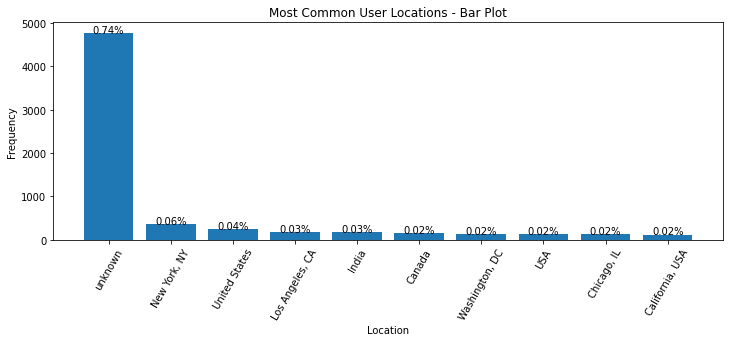

In [ ]:
tweet_bar_plot(locations, 'Most Common User Locations - Bar Plot', 'Location', 'Frequency', show_perc=True, image_name = 'user_location')

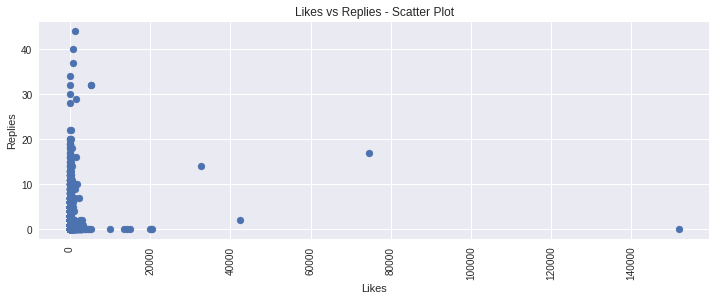

In [ ]:
plt.figure(figsize = (12,4))
plt.xticks(rotation = 90)

# take speed range column names and delete "speed" substring
x = tweet_data.n_likes
y = tweet_data.n_replies

plt.scatter(x, y)  

plt.title('Likes vs Replies - Scatter Plot')
plt.xlabel('Likes')
plt.ylabel('Replies')

#fig.savefig('{}.png'.format(image_name), bbox_inches='tight')
plt.show()

In [ ]:
# we could determine which are the most active users (i.e. who post more tweets than other users)

active_user = collections.Counter(tweet_data.user_name).most_common(10)
active_user = {user : count for user, count in active_user}
active_user = dict(sorted(active_user.items(), key=operator.itemgetter(1),reverse=True))

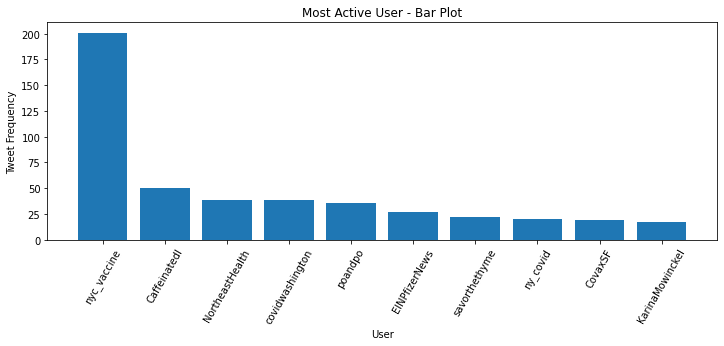

In [ ]:
tweet_bar_plot(active_user, 'Most Active User - Bar Plot', 'User', 'Tweet Frequency', image_name = 'active_user')

In [ ]:
# we could determine the general sentiment on collections tweets about Pfizer

fig = plt.figure(figsize = (10, 10))
sentiment = collections.Counter(tweet_data.tweet_sentiment)
plt.pie(sentiment.values(), labels = sentiment.keys(), autopct = "%.2f")
plt.title("Tweet Sentiment - Pie Chart Plot")


image_name = 'general_sentiment'

if len(image_name) > 0:
  plt.savefig('general_sentiment.png', bbox_inches = 'tight')
  
plt.show()

### Twitter Engagement Rate

---



An interesting analysis might be done over the **Engagement Rate**, that is one of the main metrics of "importancy" to a user; so, how much a (tweet) user is influence.

A proper defintion for the Engagement Rate: it is a metric often used to track how actively involved with your content your audience is and how effective your brand campaigns are. Engaged consumers interact with brands through interactions such as “likes,” comments and social sharing.

From the official Twitter Page it is reported that '_the Engagementsis given by Total number of times a user interacted with a Tweet. Clicks anywhere on the Tweet, including Retweets, replies, follows, likes, links, cards, hashtags, embedded media, username, profile photo, or Tweet expansion. While, the Engagement rate is the Number of engagements divided by impressions_'.

Where the _impressions_ is the times a user is served a Tweet in timeline or search results.

In our case we have used a simplified formula for the Engagement Rate:

$Engagement Rate = \frac{n\_likes + n\_replies + n\_retweet}{n\_followers} \cdot 100$

Note

In case a Twitter user has no followers, it's Engagement Rate is basically zero.

In [ ]:
engagement_rate = lambda n_retweet, n_likes, n_replies, n_followers: ((n_retweet + n_likes + n_replies) / n_followers) * 100 if n_followers > 0 else 0

In [ ]:
user_engagement_rate = {row.user_id : engagement_rate(row.n_retweet, row.n_likes, row.n_replies, row.n_followers) 
                            for idx, row in tweet_data.iterrows()}

user_engagement_rate = pd.DataFrame(list(user_engagement_rate.items()), columns=['user_id', 'eng_rate'])                         
user_engagement_rate.sort_values(by=['eng_rate'], inplace=True, ascending=False)

engagement_sentiment = pd.merge(user_engagement_rate.head(10), tweet_data.loc[: ,['user_id', 'user_name', 'tweet_sentiment']],on='user_id')

In [ ]:
user_engage_rate_dict = {row.user_name : row.eng_rate for idx, row in engagement_sentiment.head(10).iterrows()}

In [ ]:
tweet_bar_plot(user_engage_rate_dict, 'User Engagement Rate - Bar Plot', 'User', 'Eng Rate', feature_label=engagement_sentiment.tweet_sentiment.to_list())

## References

- [Twitter: Terms Definitions](https://help.twitter.com/en/managing-your-account/using-the-tweet-activity-dashboard#:~:text=Engagements%3A%20Total%20number%20of%20times,of%20engagements%20divided%20by%20impressions)

- [Twitter: Engagement Metrics](https://www.klipfolio.com/resources/kpi-examples/social-media/twitter-engagement-metrics)

- [Twitter: Engagement Rate Formula](https://corporatefinanceinstitute.com/resources/knowledge/ecommerce-saas/engagement-rate/)